In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

from typing import List, Tuple, Dict

In [139]:
def plot_metrics(*,
                 base_path: str,
                 simulation_ids: List[int],
                 plot_grid_dimensions: Tuple[int, int],
                 slope: float,
                 r_stat_multiplier: float,
                 min_rim_percentage: float,
                 effective_radius_multiplier: float,
                 metric: str,
                 metric_label: str,
                 figsize: Tuple[float, float],
                 saturation_points: Dict[int, int] = None) -> Dict[int, pd.DataFrame]:
    """
    Plots metrics for the supplied simulation ids.
    Returns a dictionary of the simulations' ids to their dataframes.
    """
    result: Dict[int, pd.DataFrame] = dict()
    
    fig, axes = plt.subplots(nrows=plot_grid_dimensions[0], ncols=plot_grid_dimensions[1], figsize=figsize)
    
    plot_counter = 0
    
    for simulation_id in simulation_ids:
        filename = f'{base_path}/{slope:.2f}_{r_stat_multiplier:.2f}_{min_rim_percentage:.2f}_{effective_radius_multiplier:.2f}/{simulation_id}/statistics.csv'
        data = pd.read_csv(filename)
        data = data.rename(columns={
            'n_craters_added_in_observed_area': 'n_craters_added_in_study_region',
            'n_craters_in_observed_area': 'n_craters_in_study_region'})

        ax_row = plot_counter // plot_grid_dimensions[1]
        ax_col = plot_counter % plot_grid_dimensions[1]
        ax = axes[ax_row][ax_col]
        
        ax.plot(data.n_craters_added_in_study_region, data[metric])
        ax.set_xlabel('Craters Generated')
        ax.set_ylabel(metric_label)
        
        if saturation_points and simulation_id in saturation_points:
            ax.axvline(x=saturation_points[simulation_id], ls="--")
        
        
        result[simulation_id] = data
        
        plot_counter += 1
        
    return result

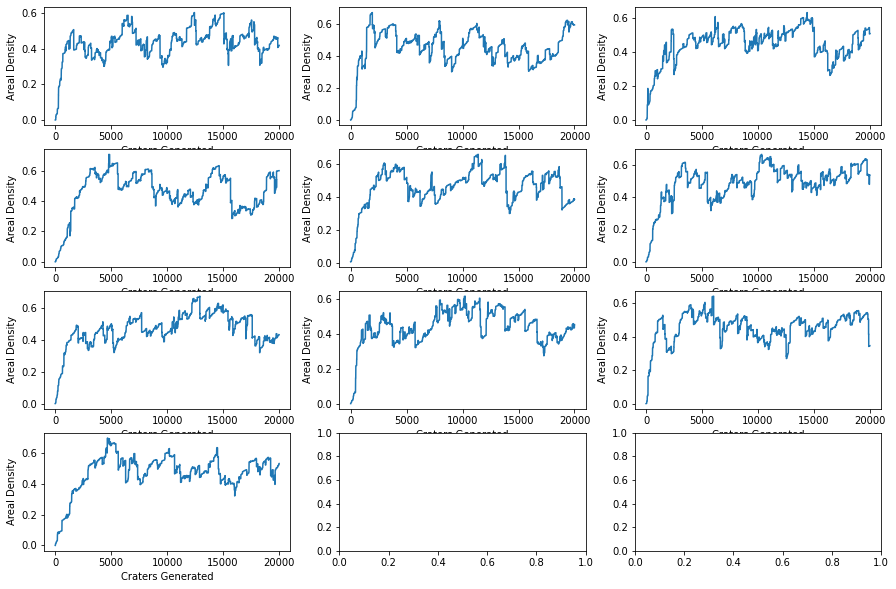

In [140]:
# For run 1.00_3.00_0.40_1.90
data = plot_metrics(base_path='/home/mason/full_runs/python/stop_condition_testing/',
                    simulation_ids=list(range(1, 11)),
                    plot_grid_dimensions=(4, 3),
                    slope=1.00,
                    r_stat_multiplier=3.00,
                    min_rim_percentage=0.40,
                    effective_radius_multiplier=1.50,
                    metric="areal_density",
                    metric_label="Areal Density",
                    figsize=(15, 10))

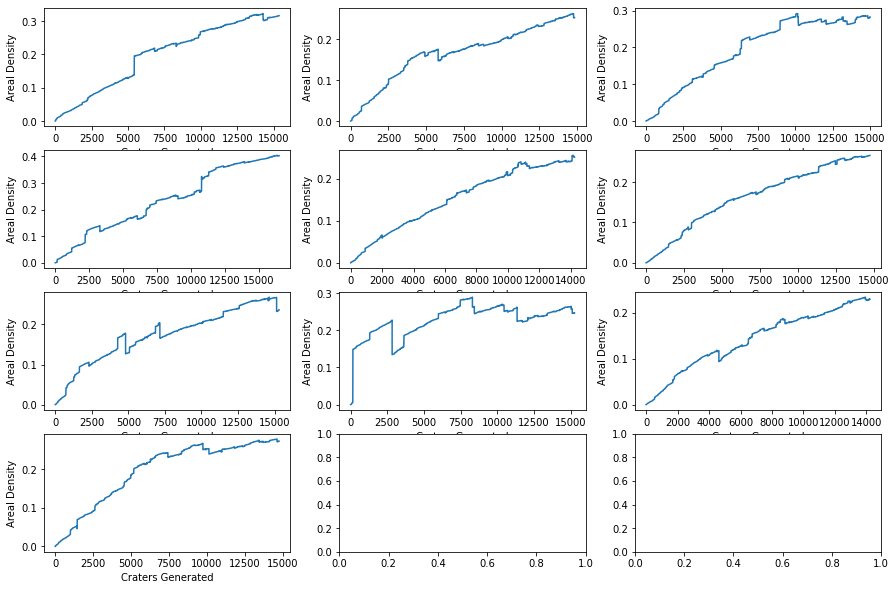

In [138]:
# For run 2.00_5.00_0.60_1.90
data = plot_metrics(base_path='/home/mason/full_runs/python/stop_condition_testing/',
                    simulation_ids=list(range(1, 11)),
                    plot_grid_dimensions=(4, 3),
                    slope=2.00,
                    r_stat_multiplier=5.00,
                    min_rim_percentage=0.60,
                    effective_radius_multiplier=1.90,
                    metric="areal_density",
                    metric_label="Areal Density",
                    figsize=(15, 10))

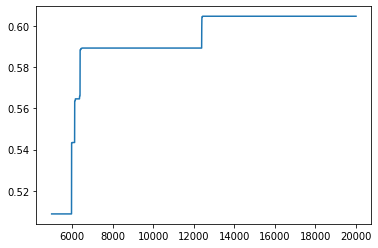

In [141]:
# Investigate behavior of rolling max
min_periods = 5000
d = data[1]
metric = d.areal_density
rolling_metric = metric.expanding(min_periods=min_periods).max()
plt.plot(d.n_craters_added_in_study_region, rolling_metric)

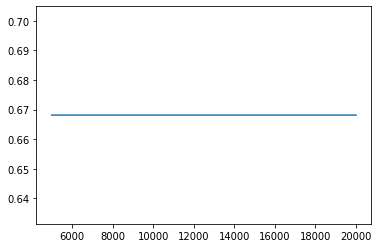

In [142]:
# Investigate behavior of rolling max
window = 5000
d = data[2]
metric = d.areal_density
rolling_metric = metric.expanding(min_periods=window).max()
plt.plot(d.n_craters_added_in_study_region, rolling_metric)

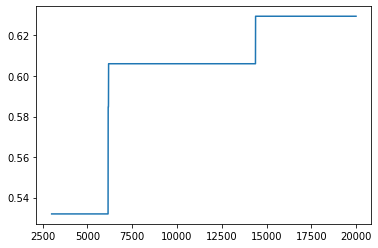

In [143]:
# Investigate behavior of rolling max
window = 3000
d = data[3]
metric = d.areal_density
rolling_metric = metric.expanding(min_periods=3000).max()
plt.plot(d.n_craters_added_in_study_region, rolling_metric)

In [150]:
# Attempted metric: max areal_density has remained stable for half the current runtime
min_craters = 5000

for i, d in data.items():
    metric1 = d.areal_density
    metric2 = d.n_craters_in_study_region
    
    found_max = 0
    for index in range(min_craters, len(metric)):
        left_index = index // 3 * 2
        if metric1[:left_index].max() == metric1[:index].max() and metric2[:left_index].max() == metric2[:index].max():
            found_max = index
            break
            
    print(f"Found max for {i} at index {found_max}")

Found max for 1 at index 5262
Found max for 2 at index 6033
Found max for 3 at index 9270
Found max for 4 at index 15981
Found max for 5 at index 7491
Found max for 6 at index 7818
Found max for 7 at index 6390
Found max for 8 at index 0
Found max for 9 at index 9060
Found max for 10 at index 7026


In [93]:
# Investigate deviance from median
window = 3000

d = data[1]
metric = d.areal_density
rolling_median = metric.rolling(window, min_periods=100).mean()
rolling_std = metric.rolling(window, min_periods=100).std()
rolling_lower = rolling_median - 1.96 * rolling_std
rolling_upper = rolling_median + 1.96 * rolling_std
within_bounds = ((metric < rolling_upper) & (metric > rolling_lower)).rolling(window, min_periods=100).mean()

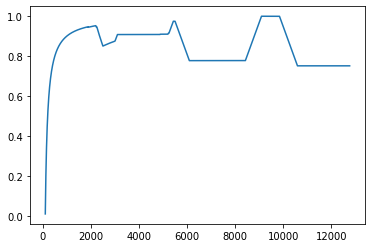

In [94]:
plt.plot(d.n_craters_added_in_study_region, within_bounds)

(array([ 663., 1258.,  974., 2540., 3281., 3881., 1043., 1547.,  952.,
         861.]),
 array([0.29674962, 0.32754141, 0.35833319, 0.38912498, 0.41991677,
        0.45070855, 0.48150034, 0.51229213, 0.54308392, 0.5738757 ,
        0.60466749]),
 <BarContainer object of 10 artists>)

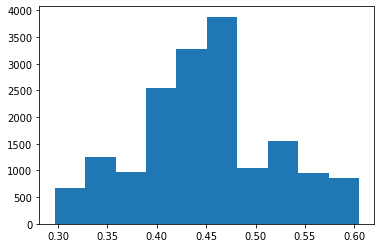

In [70]:
plt.hist(metric[3000:])

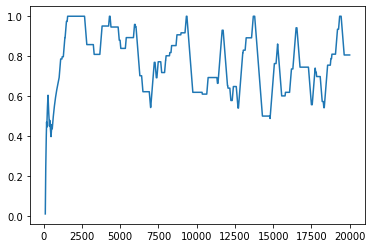

In [60]:
plt.plot(d.n_craters_added_in_study_region, within_bounds)

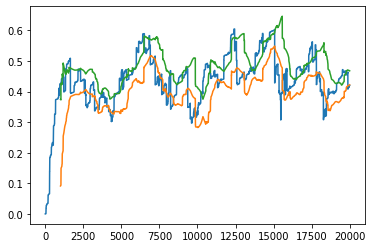

In [49]:
plt.plot(d.n_craters_added_in_study_region, metric)
plt.plot(d.n_craters_added_in_study_region, rolling_lower)
plt.plot(d.n_craters_added_in_study_region, rolling_upper)

In [ ]:
rolling_max.

In [ ]:
import statsmodels.api as sm

In [ ]:
from statsmodels.regression.rolling import RollingOLS

X = data[1].n_craters_added_in_study_region
X = sm.add_constant(X)
Y = data[1].areal_density

model = RollingOLS(Y, X, window=10000)
f = model.fit()

In [ ]:
threshold = (2.5*3)**2*np.pi / 10000**2 / 100

d = f.params
d["is_saturated"] = d.n_craters_added_in_study_region < threshold
plt.plot(data[1].n_craters_added_in_study_region, d.n_craters_added_in_study_region)
plt.axhline(y=threshold)

In [ ]:
s = d.is_saturated.rolling(1000).agg("mean") > 0.95
s[s]

In [ ]:
d[d.is_saturated][:40]

In [ ]:
# For run 1.50_3.00_0.60_1.90
saturation_points = {
    1: 4246,
    2: 3053,
}
data = plot_metrics(base_path='/home/mason/full_runs/python/testing/',
                    simulation_ids=list(range(1, 3)),
                    plot_grid_dimensions=(2, 2),
                    slope=1.00,
                    r_stat_multiplier=3.00,
                    min_rim_percentage=0.40,
                    effective_radius_multiplier=1.50,
                    metric="areal_density",
                    metric_label="Areal Density",
                    figsize=(15, 10),
                    saturation_points=saturation_points)

In [ ]:
f.plot_recursive_coefficient()

In [ ]:
f.params.dropna()[-100:]

In [ ]:
data[1].areal_density

In [ ]:
skip_size = 

res = []
for x in range(len(data[1]) - window_size):
    sl = data[1].iloc[x:x + window_size].areal_density
    
    m = np.mean(sl)
    sd = np.std(sl)
    norm = (sl - m) / sd
    res.append(np.mean((norm > 1.96) | (norm < -1.96)))
               